<h1><center>Lab2: Spoken Digits Recognition</center></h1>

![Image of Yaktocat](images/logo.jpg)

## Dataset Description
* 9 spoken digits, 'one', 'two', ..., 'nine', from 15 speakers (2 samples have been excluded)

### a) Preparatory 

In [2]:
import librosa
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.base import BaseEstimator
import math
from sklearn.naive_bayes import GaussianNB
import torch
from torch import nn
import torch.nn.functional as F
from random import choice
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from glob import glob
from pomegranate import *
from  matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

dataRelPath= 'data/digits/'
picklesPath= 'pickles/'
imagesPath= 'images/'

#### Step 1

open wav files with praat

![Image of Yaktocat](images/open_wav_files_praat.jpg)

given that the pronunciation of 'one' is written as 'wuhn'<br>
let's split it into 'w'+'uh'+'n' in order to isolate the vowel 'uh'

![Image of Yaktocat](images/one_to_w_uh_n.jpg)

The previous two steps were apllied both to 'onetwothree1.wav' and 'onetwothree8.wav'<br>
Here are the results:

<center> <h3>Male</h3> </center>

|   vowels 	|  Pitch(Hz) 	|  F1(Hz) 	|  F2(Hz) 	|  F3(Hz) 	|
|:------:	|:---------:	|:------:	|:------:	|:------:	|
|   uh   	|    134    	|   788  	|  1162  	|  2345  	|
|   oo   	|    131    	|   350  	|  1769  	|  2312  	|
|   ee   	|    130    	|   386  	|  1981  	|  2437  	|


<center> <h3>Female</h3> </center>

| vowels 	| Pitch(Hz) 	| F1(Hz) 	| F2(Hz) 	| F3(Hz) 	|
|:------:	|:---------:	|:------:	|:------:	|:------:	|
|   uh   	|    176    	|   911  	|  1698  	|  3098  	|
|   oo   	|    188    	|   346  	|  1723  	|  2678  	|
|   ee   	|    193    	|   912  	|  2642  	|  2917  	|

We can see that
* Man produces the vowels in a lower pitch (fundamental frequency) than the woman
* Given that formants are related to vocal tract shape (at least F1 and F2),<br>
  we can see that they might be used as features in the process of these vowels identification

#### Step 2

In [457]:
def data_parser(directory_in_str):
    directory= os.fsencode(directory_in_str)
    filenames=[]
    speakers= []
    digits= []
    for filename in os.listdir(directory):
        if os.name == 'nt': #decode filename if python runson windows
            filename= os.fsdecode(filename)
        filenames.append(filename)
        speakers.append(re.match(r'[a-z]+(\d+)\.wav',filename)[1]) #each filename ends with speaker id 
        digits.append(re.match(r'([a-z]+)\d+\.wav',filename)[1])
        
    #return np.array(filenames), np.array(speakers), np.array(digits)
    return np.array(filenames),np.array(speakers),np.array(digits)

In [458]:
filenames, speakers, digits= data_parser(dataRelPath)

#### Step 3

use hamming!!

In [459]:
sr= 16000 # sampling rate: 16kHz
mfcc_coef= 13 # keep the first 13 coefficients
step= int(0.01*sr) #10ms
win= int(0.025*sr) #25ms

MFCCs,Ds,DDs= [],[],[]

for filename in filenames:
    y, _ = librosa.core.load(dataRelPath+filename, sr=sr)
    M= librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=step, n_fft=win)
    
    MFCCs.append(M.reshape((1,-1))[0]) #-1 means "whatever it takes"
    Ds.append(librosa.feature.delta(M, order=1).reshape((1,-1))[0])
    DDs.append(librosa.feature.delta(M, order=2).reshape((1,-1))[0])
    
MFCCs,Ds,DDs= np.array(MFCCs),np.array(Ds),np.array(DDs)

#### step 4

In [460]:
n1= 'four'
n2= 'seven'

#### a)

mfccs per word per speaker

In [461]:
def print_digit_mfcc(digits,Ms,digit):
    fig, ax = plt.subplots(8, 2,figsize=(40,60))
    ax = ax.flatten()
    offset= 0
    h= np.empty((13,offset)) #offset is needed in order to allocate memory
    for i,M in enumerate(Ms):
        if digits[i] == digit:
            ax[offset].hist(np.transpose(M.reshape((13,-1))[:2,:]), bins=20)
            offset+= 1
    ttl = fig.suptitle('Histograms of MFCC-1 (blue) & MFCC-2 (orange) of spoken word "{}" per speaker'.format(digit),fontsize=42)
    ttl.set_position([.5, 0.9])

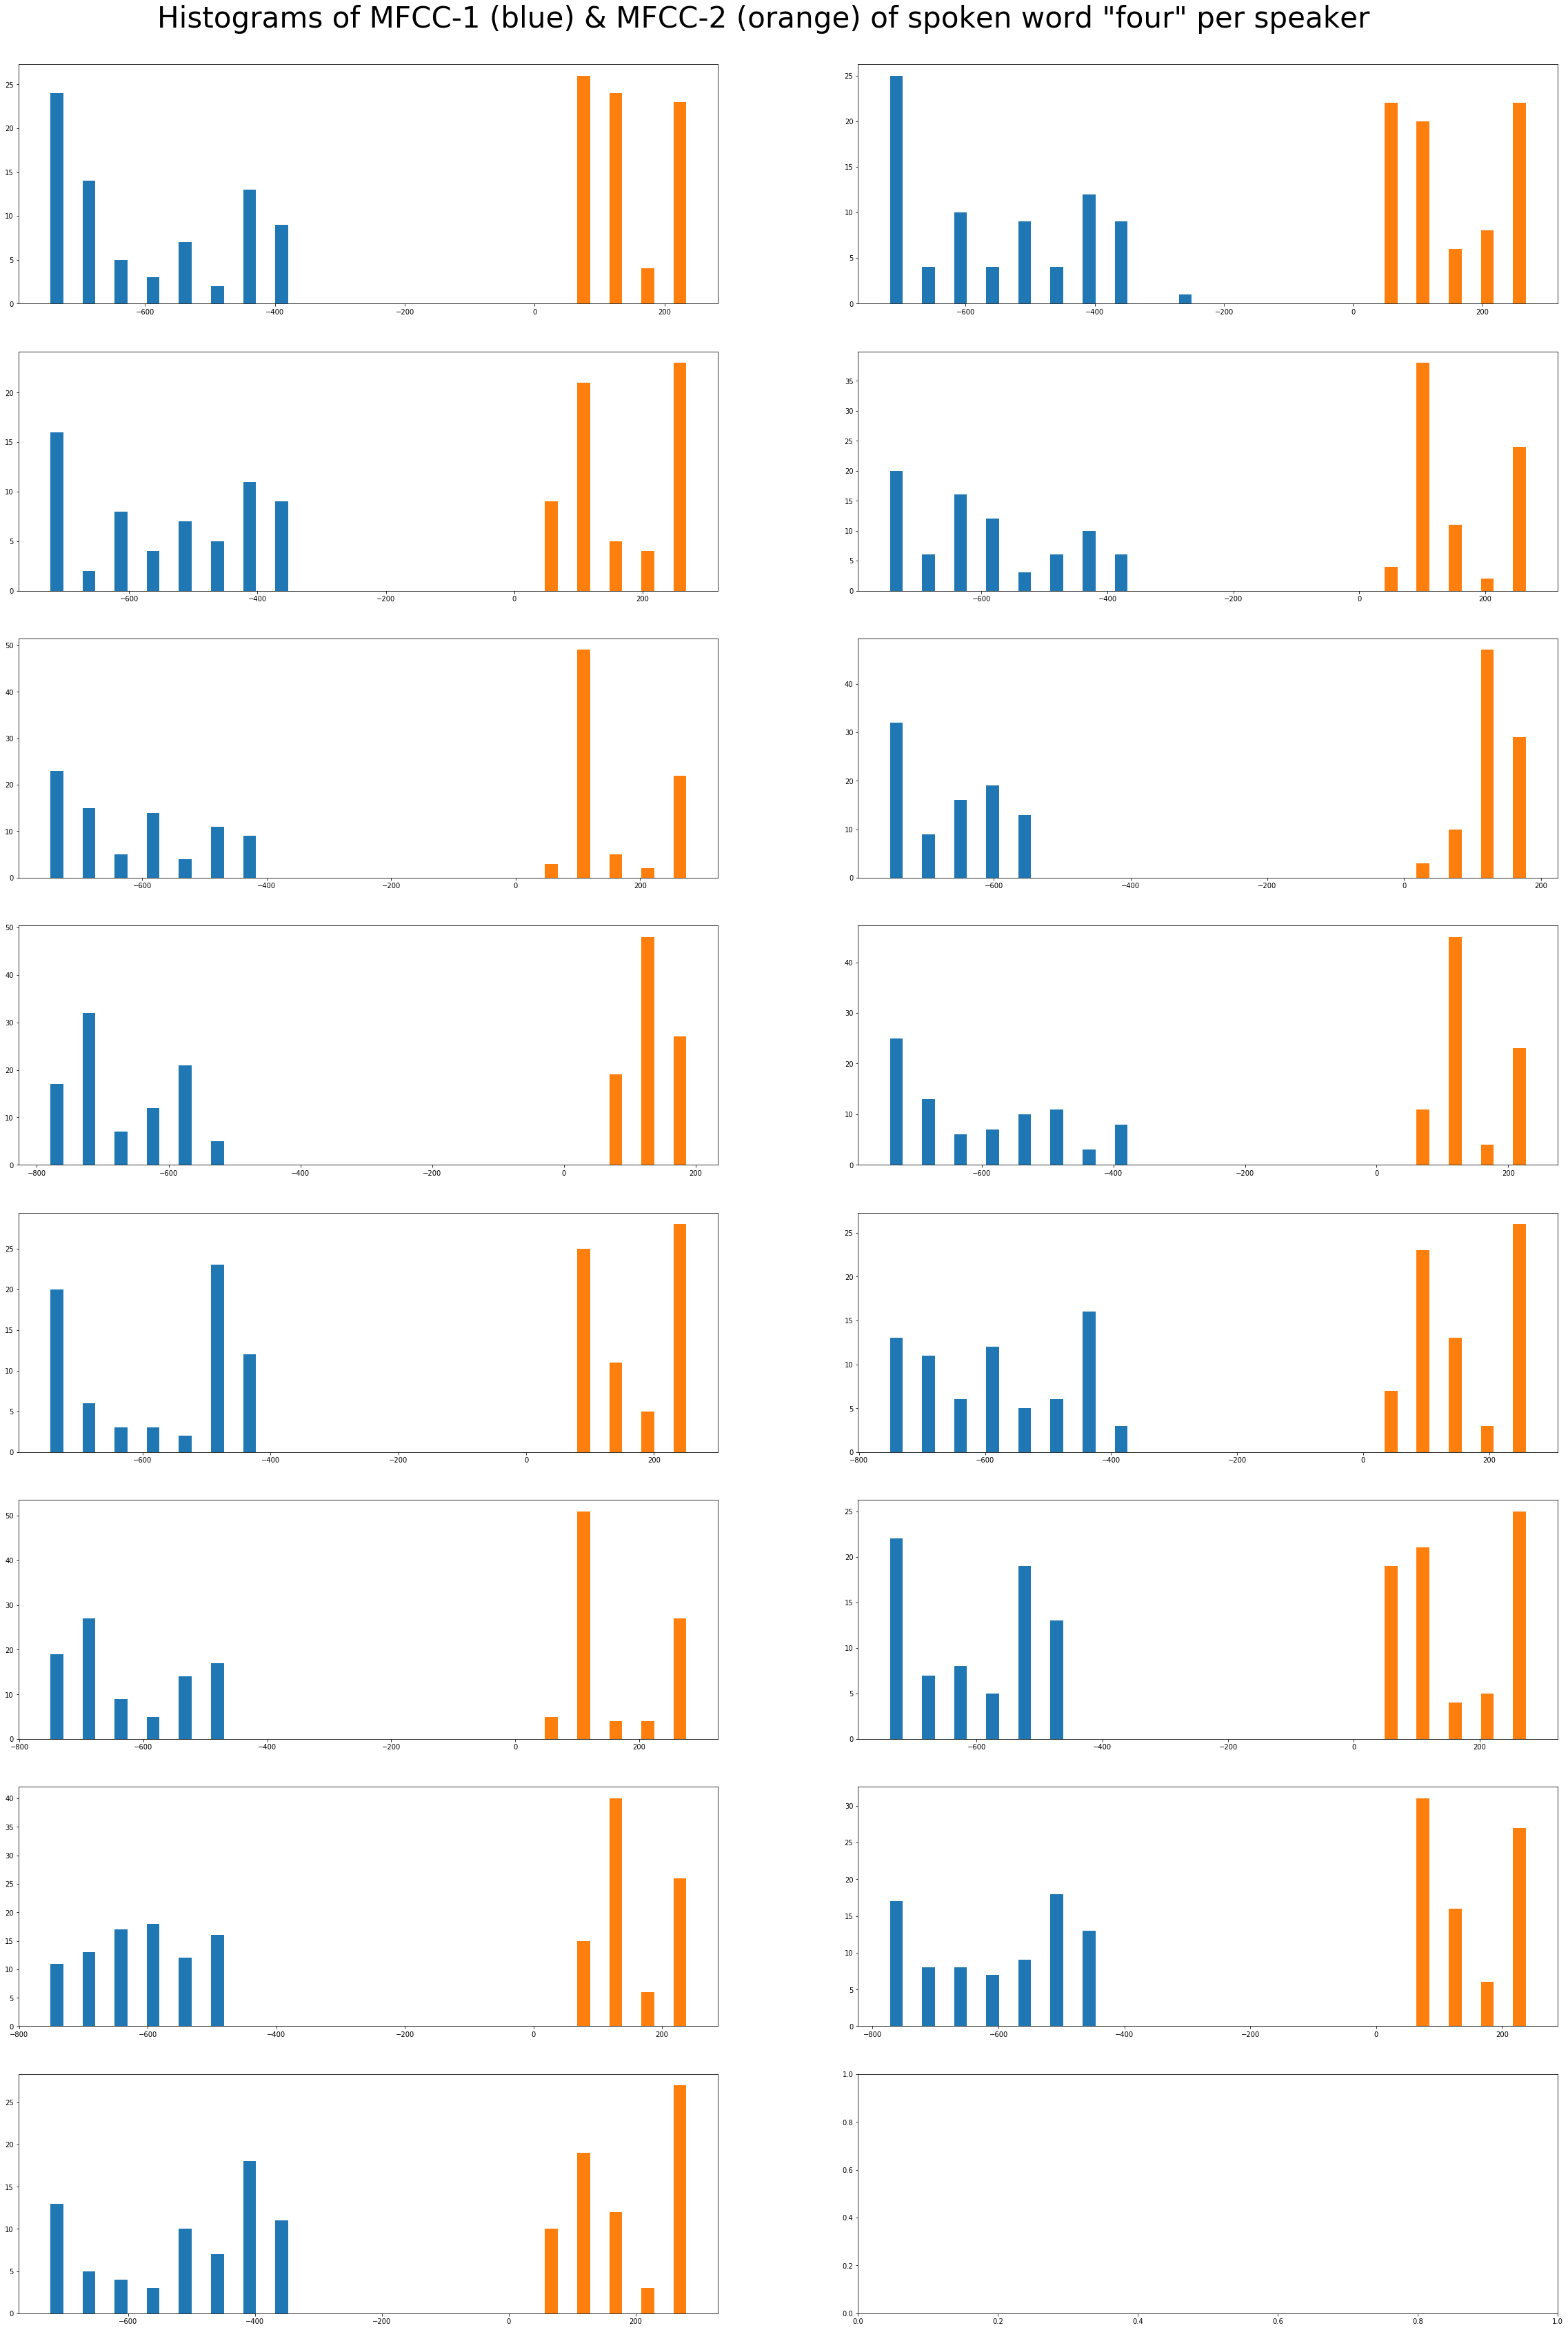

In [462]:
print_digit_mfcc(digits,MFCCs,n1)

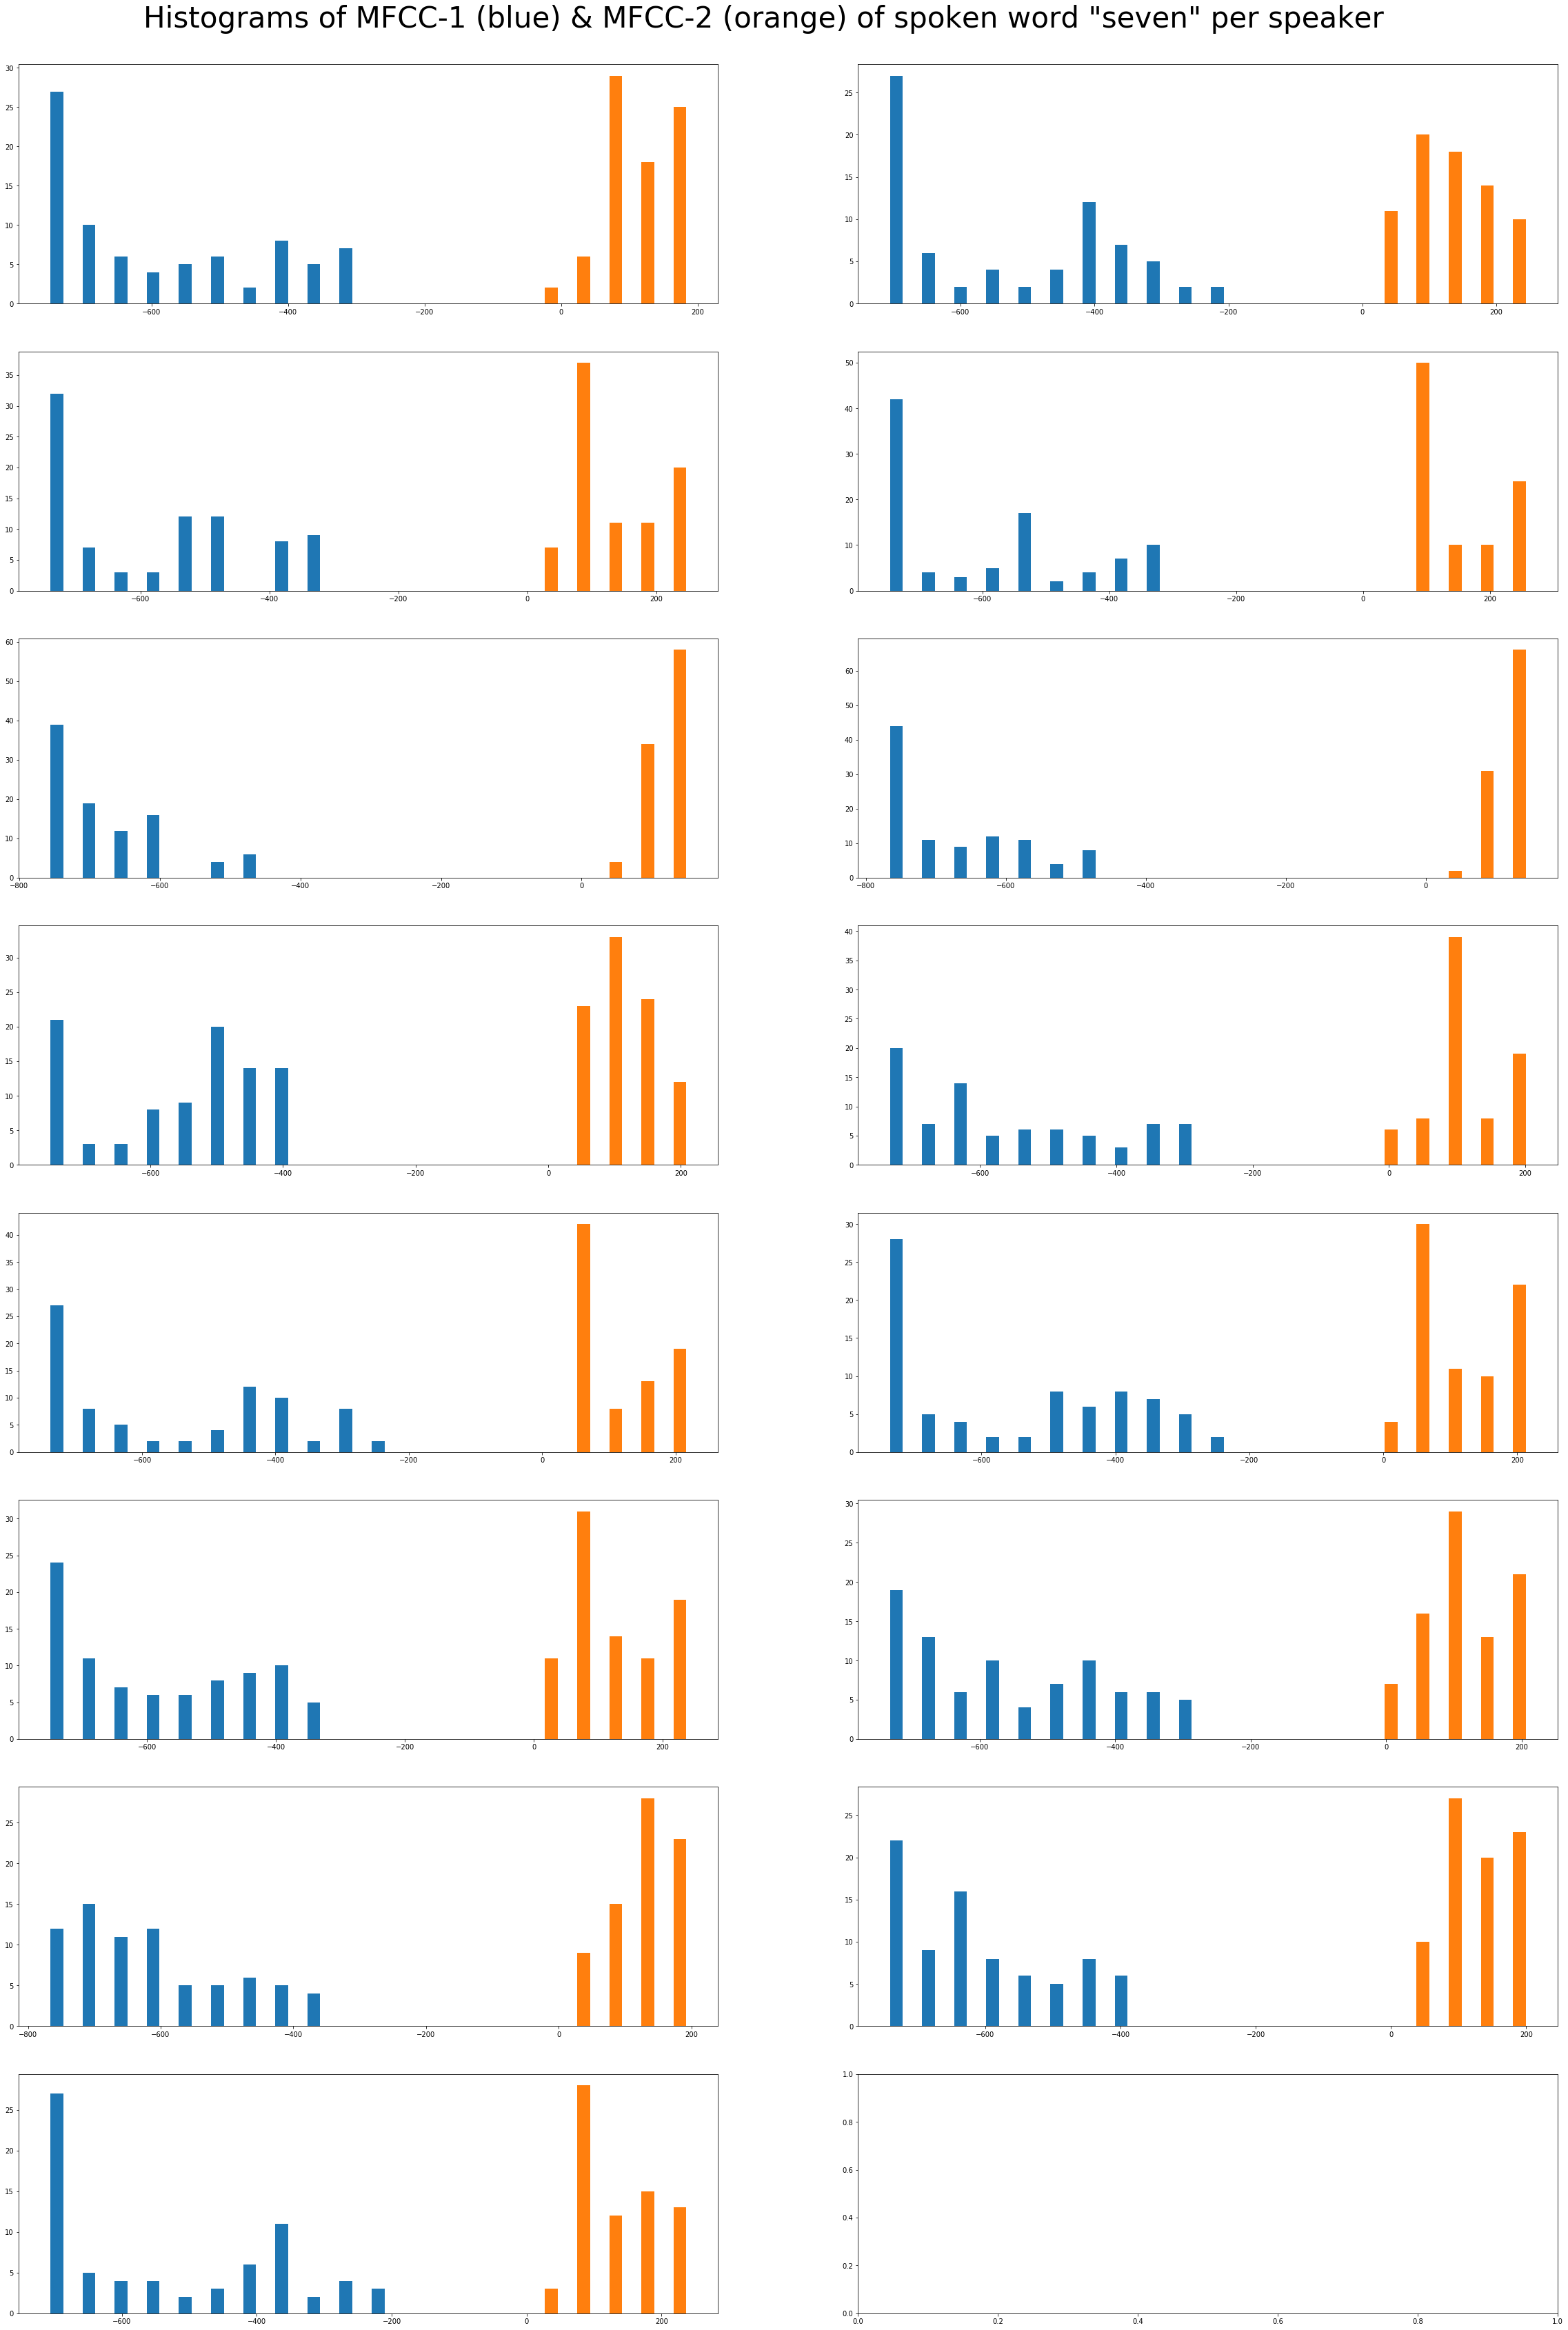

In [463]:
print_digit_mfcc(digits,MFCCs,n2)

mfccs per word (across all speakers) 

In [464]:
def append_digit_mfcc(digits,Ms,digit,mfccIndxs):
    offset= 1
    h= np.empty((13,offset)) #offset is needed in order to allocate memory
    for i,M in enumerate(Ms):
        if digits[i] == digit:
            h= np.append(h,M.reshape((13,-1)),axis=1)
    return h[mfccIndxs,offset:] #ignore first offset elements

In [465]:
mfccs_n1= append_digit_mfcc(digits,MFCCs,n1,[0,1])
mfccs_n2= append_digit_mfcc(digits,MFCCs,n2,[0,1])

In [466]:
def print_mfccs_hist_of_digit(digit,mfccs,ax,plotId):
    for i,mfcc in enumerate(mfccs):
        ax[plotId].hist(mfccs[i,:], label='MFCC-'+str(i+1))
    ax[plotId].legend(loc='upper center')
    ax[plotId].set_title('spoken word "'+digit+'"')

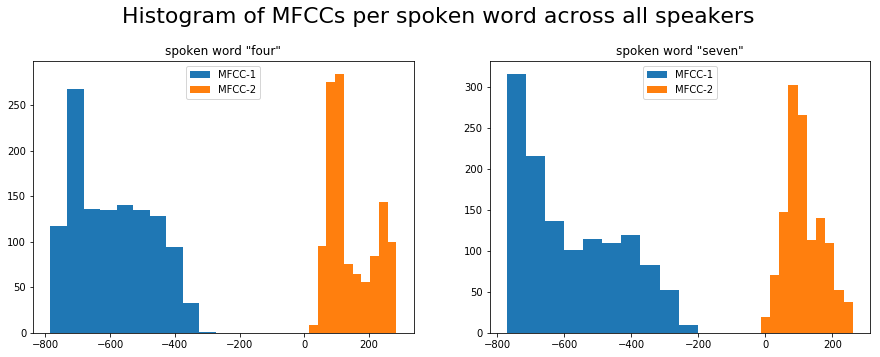

In [467]:
fig, ax = plt.subplots(1, 2,figsize=(15,5))
ax = ax.flatten()
ttl= fig.suptitle('Histogram of MFCCs per spoken word across all speakers',fontsize=22)
ttl.set_position([.5, 1.03])
for i,(n,mfccs) in enumerate(zip([n1,n2],[mfccs_n1,mfccs_n2])):
    print_mfccs_hist_of_digit(n,mfccs,ax,i)


Conclusion:
    * "four"
        * MFCC1:
            * range: [-800,-300]
            * peak: -750 (big) & around -400 (small)
        * MFCC2:
            * range: [0,250]
            * peak:  50 (big) &  200 (small)
    * "seven"
        * MFCC1: 
            * range: [-800,-200]
            * peak:
        * MFCC2:
            * range: [0,250]
            * peak:

#### b)

In [468]:
#extract MFSCs
MFSCs= []

for filename in filenames:
    y, _ = librosa.core.load(dataRelPath+filename, sr=sr)
    M= librosa.feature.melspectrogram(y=y, sr=sr, n_mels=13, hop_length=step, n_fft=win)
    
    MFSCs.append(M.reshape((1,-1))[0]) #-1 means "whatever it takes"
    
MFSCs= np.array(MFSCs)

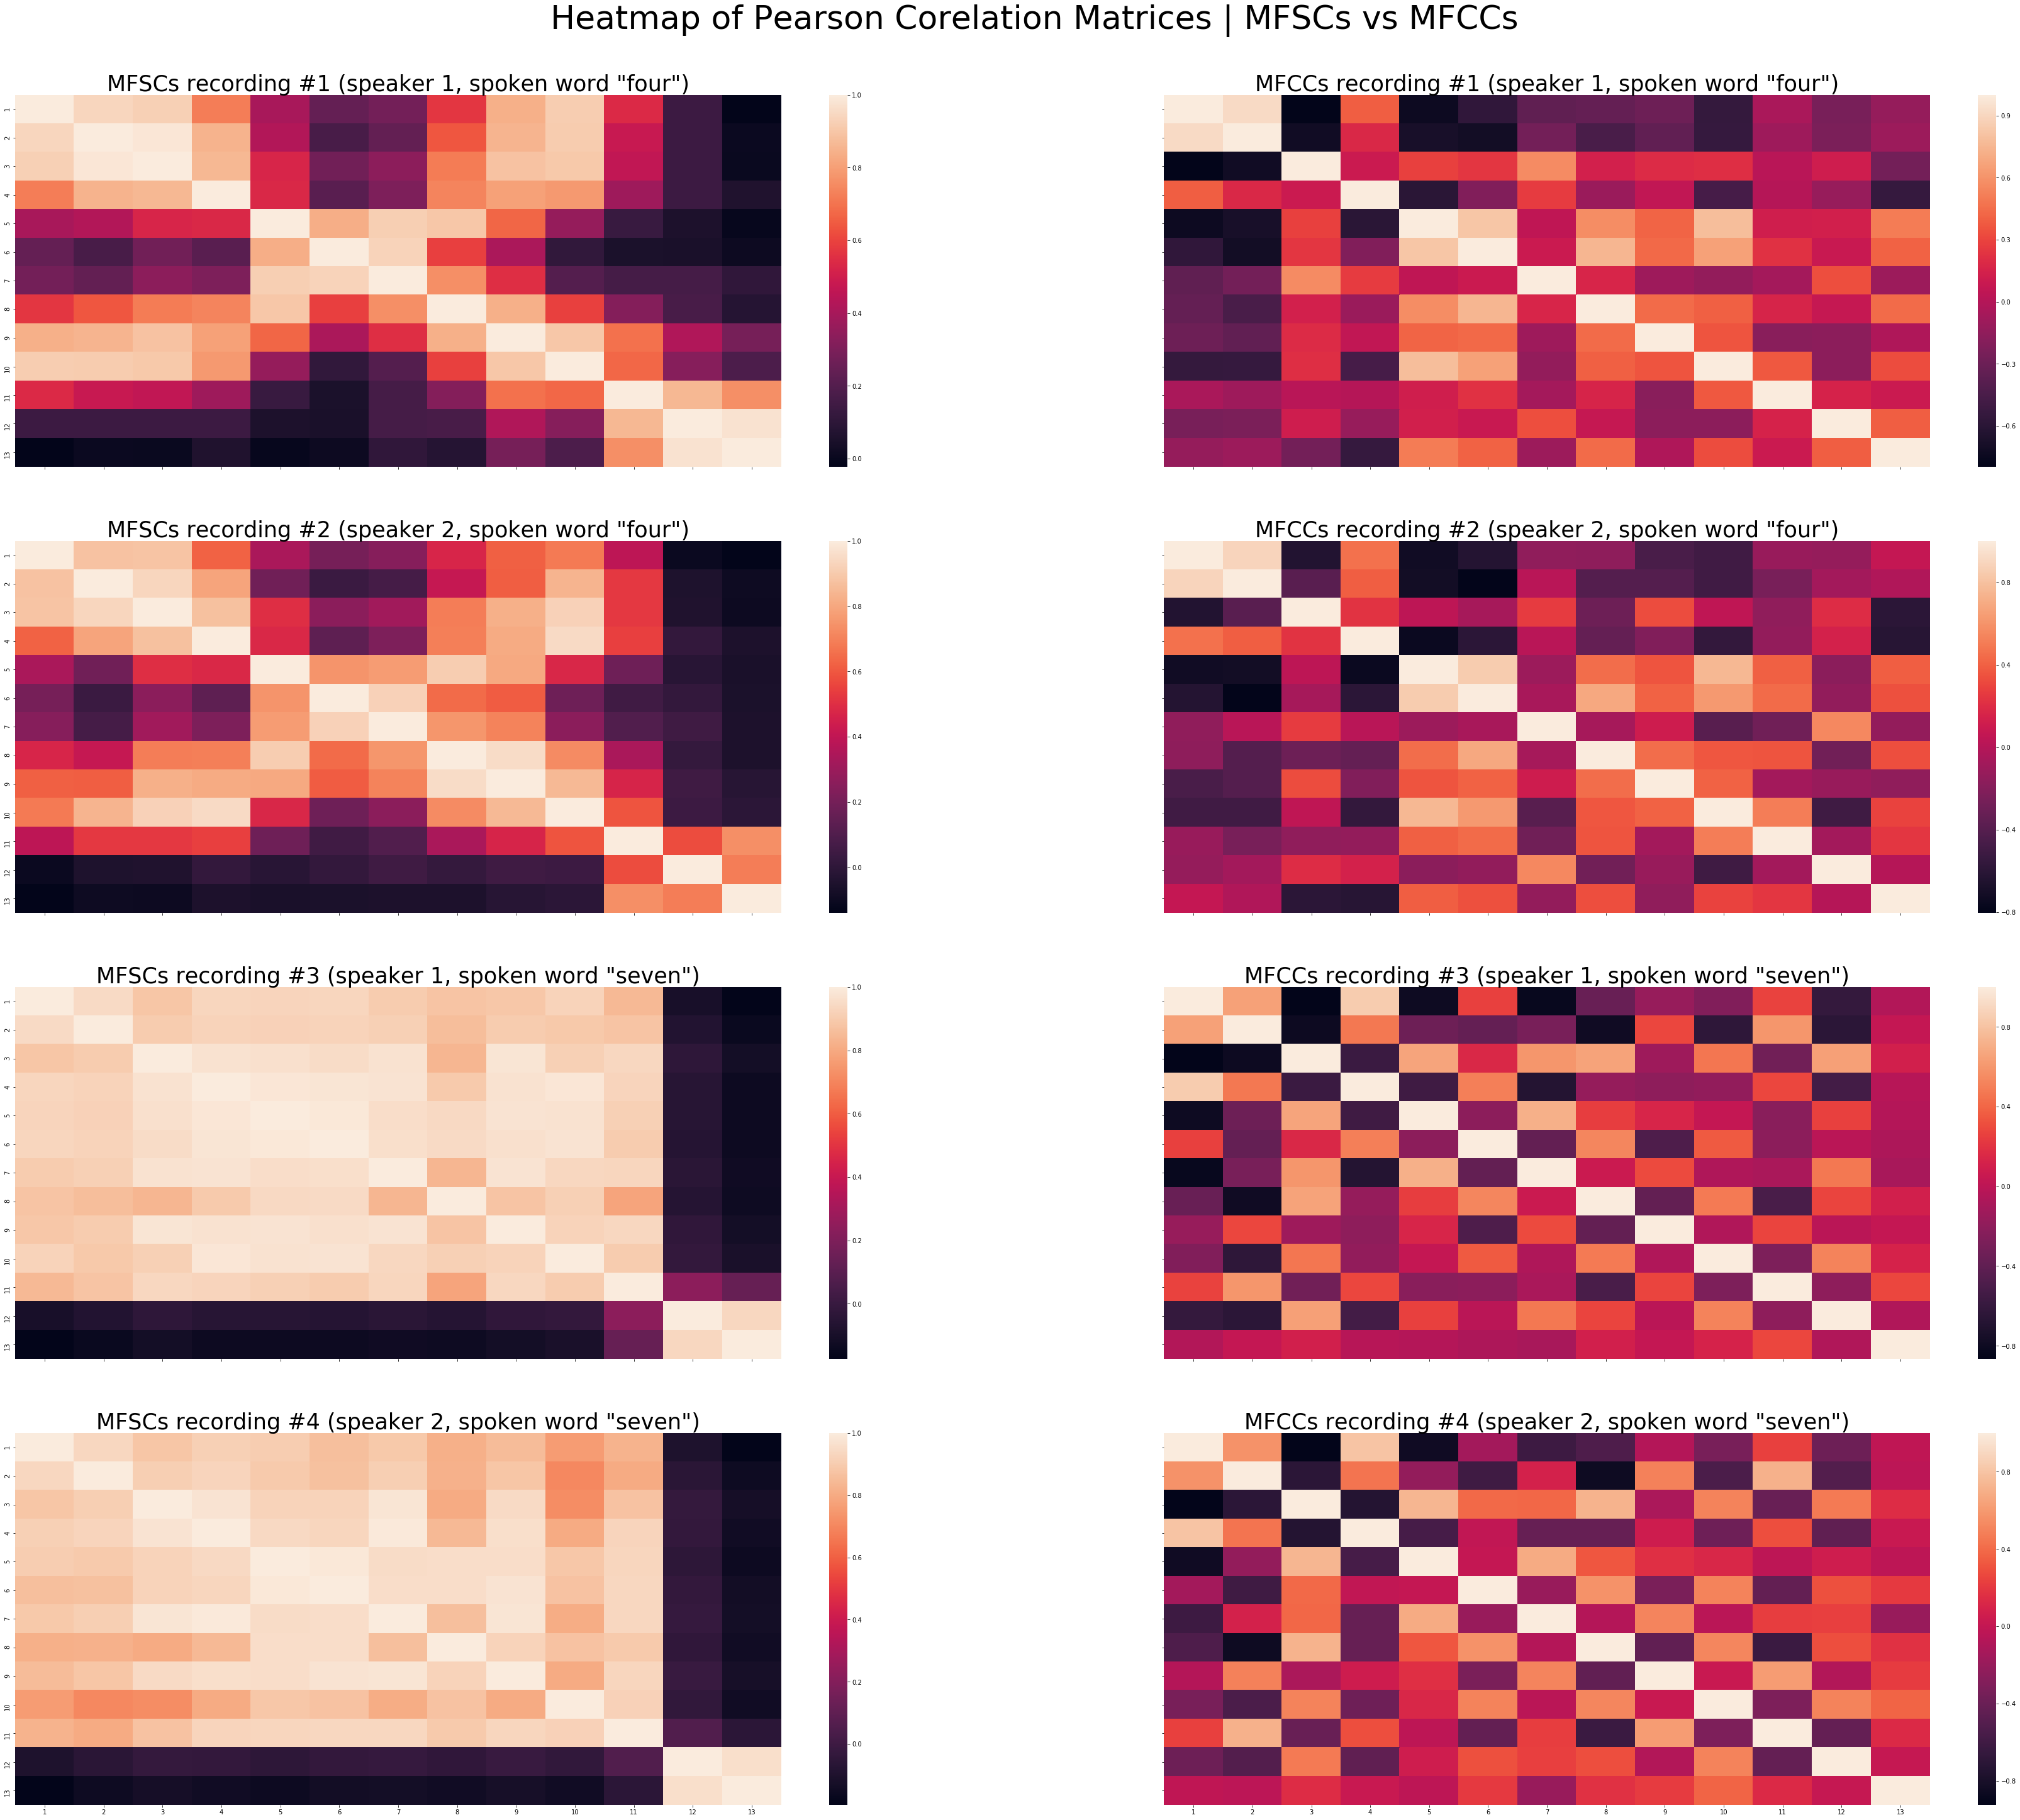

In [469]:
#compare MFSCs and MFCCs

fig, ax = plt.subplots(4, 2, sharex=True, sharey=True, figsize=(60,50))
ax = ax.flatten()
ttl= fig.suptitle('Heatmap of Pearson Corelation Matrices | MFSCs vs MFCCs',fontsize=52)
ttl.set_position([.5, 0.92])
for i,(s,d) in enumerate(zip(['1','2','1','2'],[n1,n1,n2,n2])):
    indx= np.where(np.logical_and(speakers==s,digits==d))[0][0]
    
    #MFSC
    arr= MFSCs[indx].reshape((13,-1))
    corr= np.corrcoef(arr)
    #ax[2*i].imshow(corr,cmap='hot')#, xticklabels=list(range(1,corr.shape[0]+1)), yticklabels=list(range(1,corr.shape[0]+1)))
    sns.heatmap(corr, xticklabels=list(range(1,corr.shape[0]+1)), yticklabels=list(range(1,corr.shape[0]+1)), ax=ax[2*i])
    ax[2*i].set_title('MFSCs recording #{} (speaker {}, spoken word "{}")'.format(i+1,s,d), fontsize=35)
    
    #MFCC
    arr= MFCCs[indx].reshape((13,-1))
    corr= np.corrcoef(arr)
    #ax[2*i+1].imshow(corr,cmap='hot')#, xticklabels=list(range(1,corr.shape[0]+1)), yticklabels=list(range(1,corr.shape[0]+1)))
    sns.heatmap(corr, xticklabels=list(range(1,corr.shape[0]+1)), yticklabels=list(range(1,corr.shape[0]+1)), ax=ax[2*i+1])
    ax[2*i+1].set_title('MFCCs recording #{} (speaker {}, spoken word "{}")'.format(i+1,s,d), fontsize=35)

It is obvious that MFCCs and less correlated than MFSCs,<br>
so they are better features for this ASR task.

### step 5

In [470]:
combinedFM= []
combinedFS= []
for i in range(len(filenames)):
    tmp= np.reshape(MFCCs[i],(13,-1))
    thisFM= tmp.mean(axis=1)
    thisFS= tmp.std(axis=1)
    
    tmp= np.reshape(Ds[i],(13,-1))
    thisFM= np.append(thisFM, tmp.mean(axis=1), axis=0)
    thisFS= np.append(thisFS, tmp.std(axis=1), axis=0)
    
    tmp= np.reshape(DDs[i],(13,-1))
    thisFM= np.append(thisFM, tmp.mean(axis=1), axis=0)
    thisFS= np.append(thisFS, tmp.std(axis=1), axis=0)
    
    combinedFM.append(thisFM)
    combinedFS.append(thisFS)

combinedF= np.concatenate((combinedFM,combinedFS),axis=1)

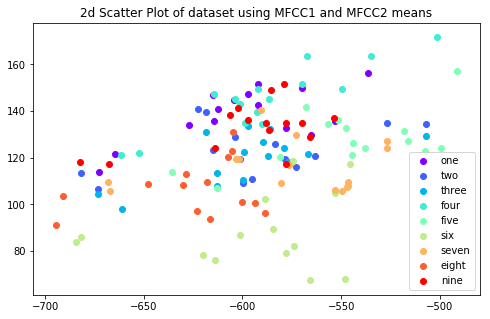

Classes cannot be distinguished through these 2 random features


In [471]:
plt.figure(figsize=(8,5))
unq_classes= ['one','two','three','four','five','six','seven','eight','nine']
colors = cm.rainbow(np.linspace(0, 1, len(unq_classes)))
for cls, clr in zip(unq_classes, colors):
    indxs= [d==cls for d in digits]
    plt.scatter(combinedF[indxs,0], combinedF[indxs,1], color=clr, label=cls)
    
plt.legend()
plt.title('2d Scatter Plot of dataset using MFCC1 and MFCC2 means')
plt.show()
print('Classes cannot be distinguished through these 2 random features')

### step 6

In [472]:
pca2= PCA(n_components=2)
combinedF_pca2= pca2.fit_transform(combinedF)
print('Percentage of variance explained by each of these 2 PCA features')
print(pca2.explained_variance_ratio_)

Percentage of variance explained by each of these 2 PCA features
[0.5880329  0.11856747]


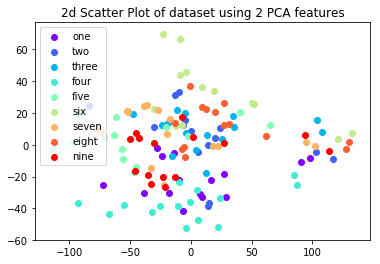

Classes cannot be distinguished through these 2 PCA features


In [473]:
unq_classes= ['one','two','three','four','five','six','seven','eight','nine']
colors = cm.rainbow(np.linspace(0, 1, len(unq_classes)))
for cls, clr in zip(unq_classes, colors):
    indxs= [d==cls for d in digits]
    plt.scatter(combinedF_pca2[indxs,0], combinedF_pca2[indxs,1], color=clr, label=cls)
    
plt.legend()
plt.title('2d Scatter Plot of dataset using 2 PCA features')
plt.show()
print('Classes cannot be distinguished through these 2 PCA features')

In [474]:
pca3= PCA(n_components=3)
combinedF_pca3= pca3.fit_transform(combinedF)
print('Percentage of variance explained by each of these 3 PCA features')
print(pca3.explained_variance_ratio_)

Percentage of variance explained by each of these 3 PCA features
[0.5880329  0.11856747 0.10831838]


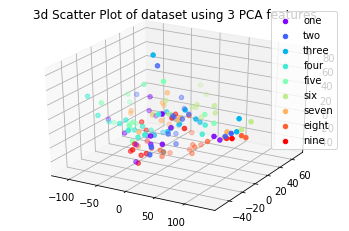

Classes cannot be distinguished neither through these 3 PCA features


In [475]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

unq_classes= ['one','two','three','four','five','six','seven','eight','nine']
colors = cm.rainbow(np.linspace(0, 1, len(unq_classes)))
for cls, clr in zip(unq_classes, colors):
    indxs= [d==cls for d in digits]
    ax.scatter(combinedF_pca3[indxs,0], combinedF_pca3[indxs,1], combinedF_pca3[indxs,2], color=clr, label=cls)
    
plt.legend()
plt.title('3d Scatter Plot of dataset using 3 PCA features')
plt.show()
print('Classes cannot be distinguished neither through these 3 PCA features')

### step 7

#### a)

In [476]:
class MyNaiveBayesClassifier(BaseEstimator):  
    
    class NotFittedError:
        pass 
    
    
    def checkType(self, *argv):
        for arg in argv:
            if type(arg) not in [list, np.ndarray]:
                print(type(arg),arg)
                raise TypeError('Input\'s type must be either python list or numpy array')
    
    def toNpArray(self, this_list):
        if type(this_list) == list:
            return np.array(this_list)
        return this_list
    
    def check_inputs_dim(self,X,Y,axis=0):
        if X.shape[axis] != Y.shape[axis]:
            raise ValueError('Invalid input dimension')
    
    def ckeck_aprioris_dim(self,y,axis=0):
        if self.aprioris_ is not None  and  np.unique(y_train).shape[axis] != self.aprioris_.shape[axis]:
                raise ValueError('Invalid input dimension')            
        
    def predict_sample(self,sample):
        pdfs_Nom= np.exp( -((sample - self.means_) ** 2) / (2*self.stds_**2) )
        pdfs_Den= self.stds_ * math.sqrt(2*math.pi)
        
        #find the index of the class with the maximum aposteriori, map that index into the real class
        return self.classes_[ np.argmax( np.prod( pdfs_Nom/pdfs_Den, axis=1) * self.aprioris_ ) ]

    
    def __init__(self, std=False, priors= None):
        self.std_= std
        self.aprioris_= priors
        self.classes_= None
        self.preds_= None 
        self.means_= None
        self.stds_= None
        
    
    def fit(self, X_train, y_train):
        self.checkType(X_train,y_train)
        
        #X_train, y_train = self.toNpArray(X_train), self.toNpArray(y_train)
        X_train= self.toNpArray(X_train)
        y_train= self.toNpArray(y_train)
        try:
            self.check_inputs_dim(X_train,y_train)
            self.ckeck_aprioris_dim(y_train)
        except ValueError:
            raise ValueError('#samples not equals #labels in train set or aprioris length is wrong')

        self.X_train= X_train
        self.y_train= y_train
        
        self.classes_= np.unique(y_train)
        
        #calc the apriori probs if they not have been passed from the user
        #if self.aprioris_ is not None:
        if self.aprioris_ is None:
             self.aprioris_= np.array( [sum(y_train == thisClass) / len(y_train) for thisClass in self.classes_])

        #calculate the mean, std for each feature for all classes
        self.means_= np.array([ X_train[y_train == digit].mean(axis=0) for digit in self.classes_])
        
        if not self.std_:
            self.stds_= np.array([ X_train[y_train == digit].std(axis=0) for digit in self.classes_])
            #prevent zero std values that causes NA pdf values
            minStd_value= self.stds_[self.stds_ > 0].min().min()
            self.stds_+= minStd_value/10
        else:
            self.stds_= self.std_*np.ones(self.means_.shape)
        return self

    def predict(self, X_test):
        if self.means_ is None or self.stds_ is None:
            raise NotFitterError("This classifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.")
        
        X_test = self.toNpArray(X_test)
        try:
            self.check_inputs_dim(self.X_train,X_test,axis=1)
        except ValueError:
            raise ValueError('#features in train and test set is inconsistent')

        self.preds_= np.array([ self.predict_sample(sample) for sample in X_test])
        return self.preds_
    
    
    def score(self, X_test, y_test):
        #Even if self.predict != None, they may belong to different X_test data 
        self.predict(X_test)
        
        X_test, y_test = self.toNpArray(X_test), self.toNpArray(y_test)
        try:
            self.check_inputs_dim(X_test,y_test)
        except ValueError:
            raise ValueError('#samples not equals #labels in test set')
        
        return np.sum(self.preds_ == y_test) / y_test.shape[0]

In [477]:
X_train, X_test, y_train, y_test = train_test_split(combinedF, digits, test_size=0.3, random_state=42)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_s= scaler.transform(X_train)
X_test_s= scaler.transform(X_test)

In [478]:
myGnb= MyNaiveBayesClassifier()
myGnb.fit(X_train_s,y_train)

gnb= GaussianNB()
gnb.fit(X_train_s,y_train)

#print('Accuracy: {:.2f}% [{} | without features scalling]'.format(myGnb.score(X_test,y_test),'My Naive Bayes'))
print('Accuracy: {:.2f} [{}]'.format(myGnb.score(X_test_s,y_test),'My Naive Bayes'))
#print('Accuracy: {:.2f}% [{} | without features scalling]'.format(gnb.score(X_test,y_test),'Sklearn Naive Bayes'))
print('Accuracy: {:.2f} [{}]'.format(gnb.score(X_test_s,y_test),'Sklearn Naive Bayes'))

Accuracy: 0.57 [My Naive Bayes]
Accuracy: 0.55 [Sklearn Naive Bayes]


#### b)

In [479]:
clfs = [
        [MyNaiveBayesClassifier(), 'My Gaussian Naive Bayes Classifier'],
        [KNeighborsClassifier(n_neighbors=3), 'k-Nearest Neighbors Classifier'],
        [svm.SVC(kernel='linear',gamma='scale'), 'SVM w/ linear kernel'],
        [svm.SVC(kernel='poly',gamma='scale'), 'SVM w/ polynomial kernel'],
        [svm.SVC(kernel='rbf',gamma='scale'), 'SVM w/ rbf kernel']
       ]

results= []
for clf, label in clfs:
    #scores= cross_validate(clf, X_train_s, y_train, cv=5, scoring='f1_weighted')['test_score']
    #results.append([scores.mean(),scores.std(),label])
    clf.fit(X_train_s,y_train)
    results.append([clf.score(X_test_s,y_test), label])


for score,label in sorted(results, key=lambda row: row[0], reverse=True):
    print("Accuracy: {:0.2f} [{}] ".format(score,label))

Accuracy: 0.70 [SVM w/ linear kernel] 
Accuracy: 0.57 [My Gaussian Naive Bayes Classifier] 
Accuracy: 0.57 [k-Nearest Neighbors Classifier] 
Accuracy: 0.55 [SVM w/ rbf kernel] 
Accuracy: 0.30 [SVM w/ polynomial kernel] 


#use more features: Volume, Energy, Pitch, Zero Crossing Rate, Spectral Centroid <--- in the main lab submission

### step 8

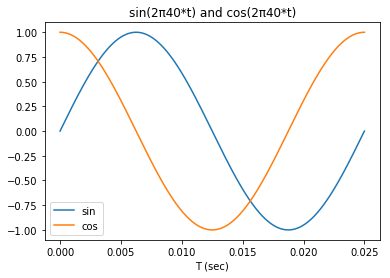

In [6]:
f= 40 # frequency: 40 Hz -> T = 0.025 sec
tot_samples= 1000
x = np.linspace(0,1/f,tot_samples) #1000 samples
sin = np.sin(2*np.pi*f*x)
cos = np.cos(2*np.pi*f*x)
plt.plot(x,sin,label='sin')
plt.plot(x,cos,label='cos')
plt.legend()
plt.title('sin(2π40*t) and cos(2π40*t)')
plt.xlabel('T (sec)')
plt.show()

In [7]:
step= 30
seqsLen= 10
totalSeqs= 200
startMax= 500
seqs_indxs,seqs_input3d,seqs_output3d = [],[],[]

for i in range(totalSeqs):
    start= choice(range(startMax))
    seq= [n*step+start for n in range(seqsLen)]
    seqs_indxs.append(seq)
    seqs_input3d.append([[x] for x in sin[seq]])
    #seqs_output3d.append([[x] for x in cos[seq]])
    seqs_output3d.append([x for x in cos[seq]])
    
seqs_input3d= np.array(seqs_input3d)
seqs_output3d= np.array(seqs_output3d)

In [8]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        #x shape: batch_size x seq_len x input_size
        batch_size = x.size(0)
        
        # Initializing hidden state for first input using method defined below
        #hidden shape: num_layers*num_directions x batch x hidden_size 
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)

        # Reshaping the outputs such that it can be fit into the fully connected layer
        #out = out.contiguous().view(-1, 10).float()
        out= out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out).view(-1, 10).float()

        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [9]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
    
model = Model(input_size=1, output_size=1, hidden_dim=7, n_layers=1)
#model = Model(input_size=1, output_size=1, hidden_dim=1, n_layers=1)
  
model.to(device)

n_epochs = 400
lr=0.01

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

seqs_input3d_t = torch.FloatTensor(torch.from_numpy(seqs_input3d).float())
seqs_output3d_t = torch.FloatTensor(seqs_output3d)#, device=device, dtype=torch.float64).float()


# Training Run
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    seqs_input3d_t.float().to(device)
    output, hidden = model(seqs_input3d_t)

    loss = criterion(output, seqs_output3d_t)
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

GPU not available, CPU used
Epoch: 10/400............. Loss: 0.3113
Epoch: 20/400............. Loss: 0.2619
Epoch: 30/400............. Loss: 0.2452
Epoch: 40/400............. Loss: 0.2333
Epoch: 50/400............. Loss: 0.2215
Epoch: 60/400............. Loss: 0.1960
Epoch: 70/400............. Loss: 0.1562
Epoch: 80/400............. Loss: 0.1393
Epoch: 90/400............. Loss: 0.1327
Epoch: 100/400............. Loss: 0.1274
Epoch: 110/400............. Loss: 0.1229
Epoch: 120/400............. Loss: 0.1208
Epoch: 130/400............. Loss: 0.1179
Epoch: 140/400............. Loss: 0.1162
Epoch: 150/400............. Loss: 0.1143
Epoch: 160/400............. Loss: 0.1125
Epoch: 170/400............. Loss: 0.1107
Epoch: 180/400............. Loss: 0.1086
Epoch: 190/400............. Loss: 0.1065
Epoch: 200/400............. Loss: 0.1047
Epoch: 210/400............. Loss: 0.1013
Epoch: 220/400............. Loss: 0.0985
Epoch: 230/400............. Loss: 0.0956
Epoch: 240/400............. Loss: 0.09

In [10]:
seqs_input3d_t.shape

torch.Size([200, 10, 1])

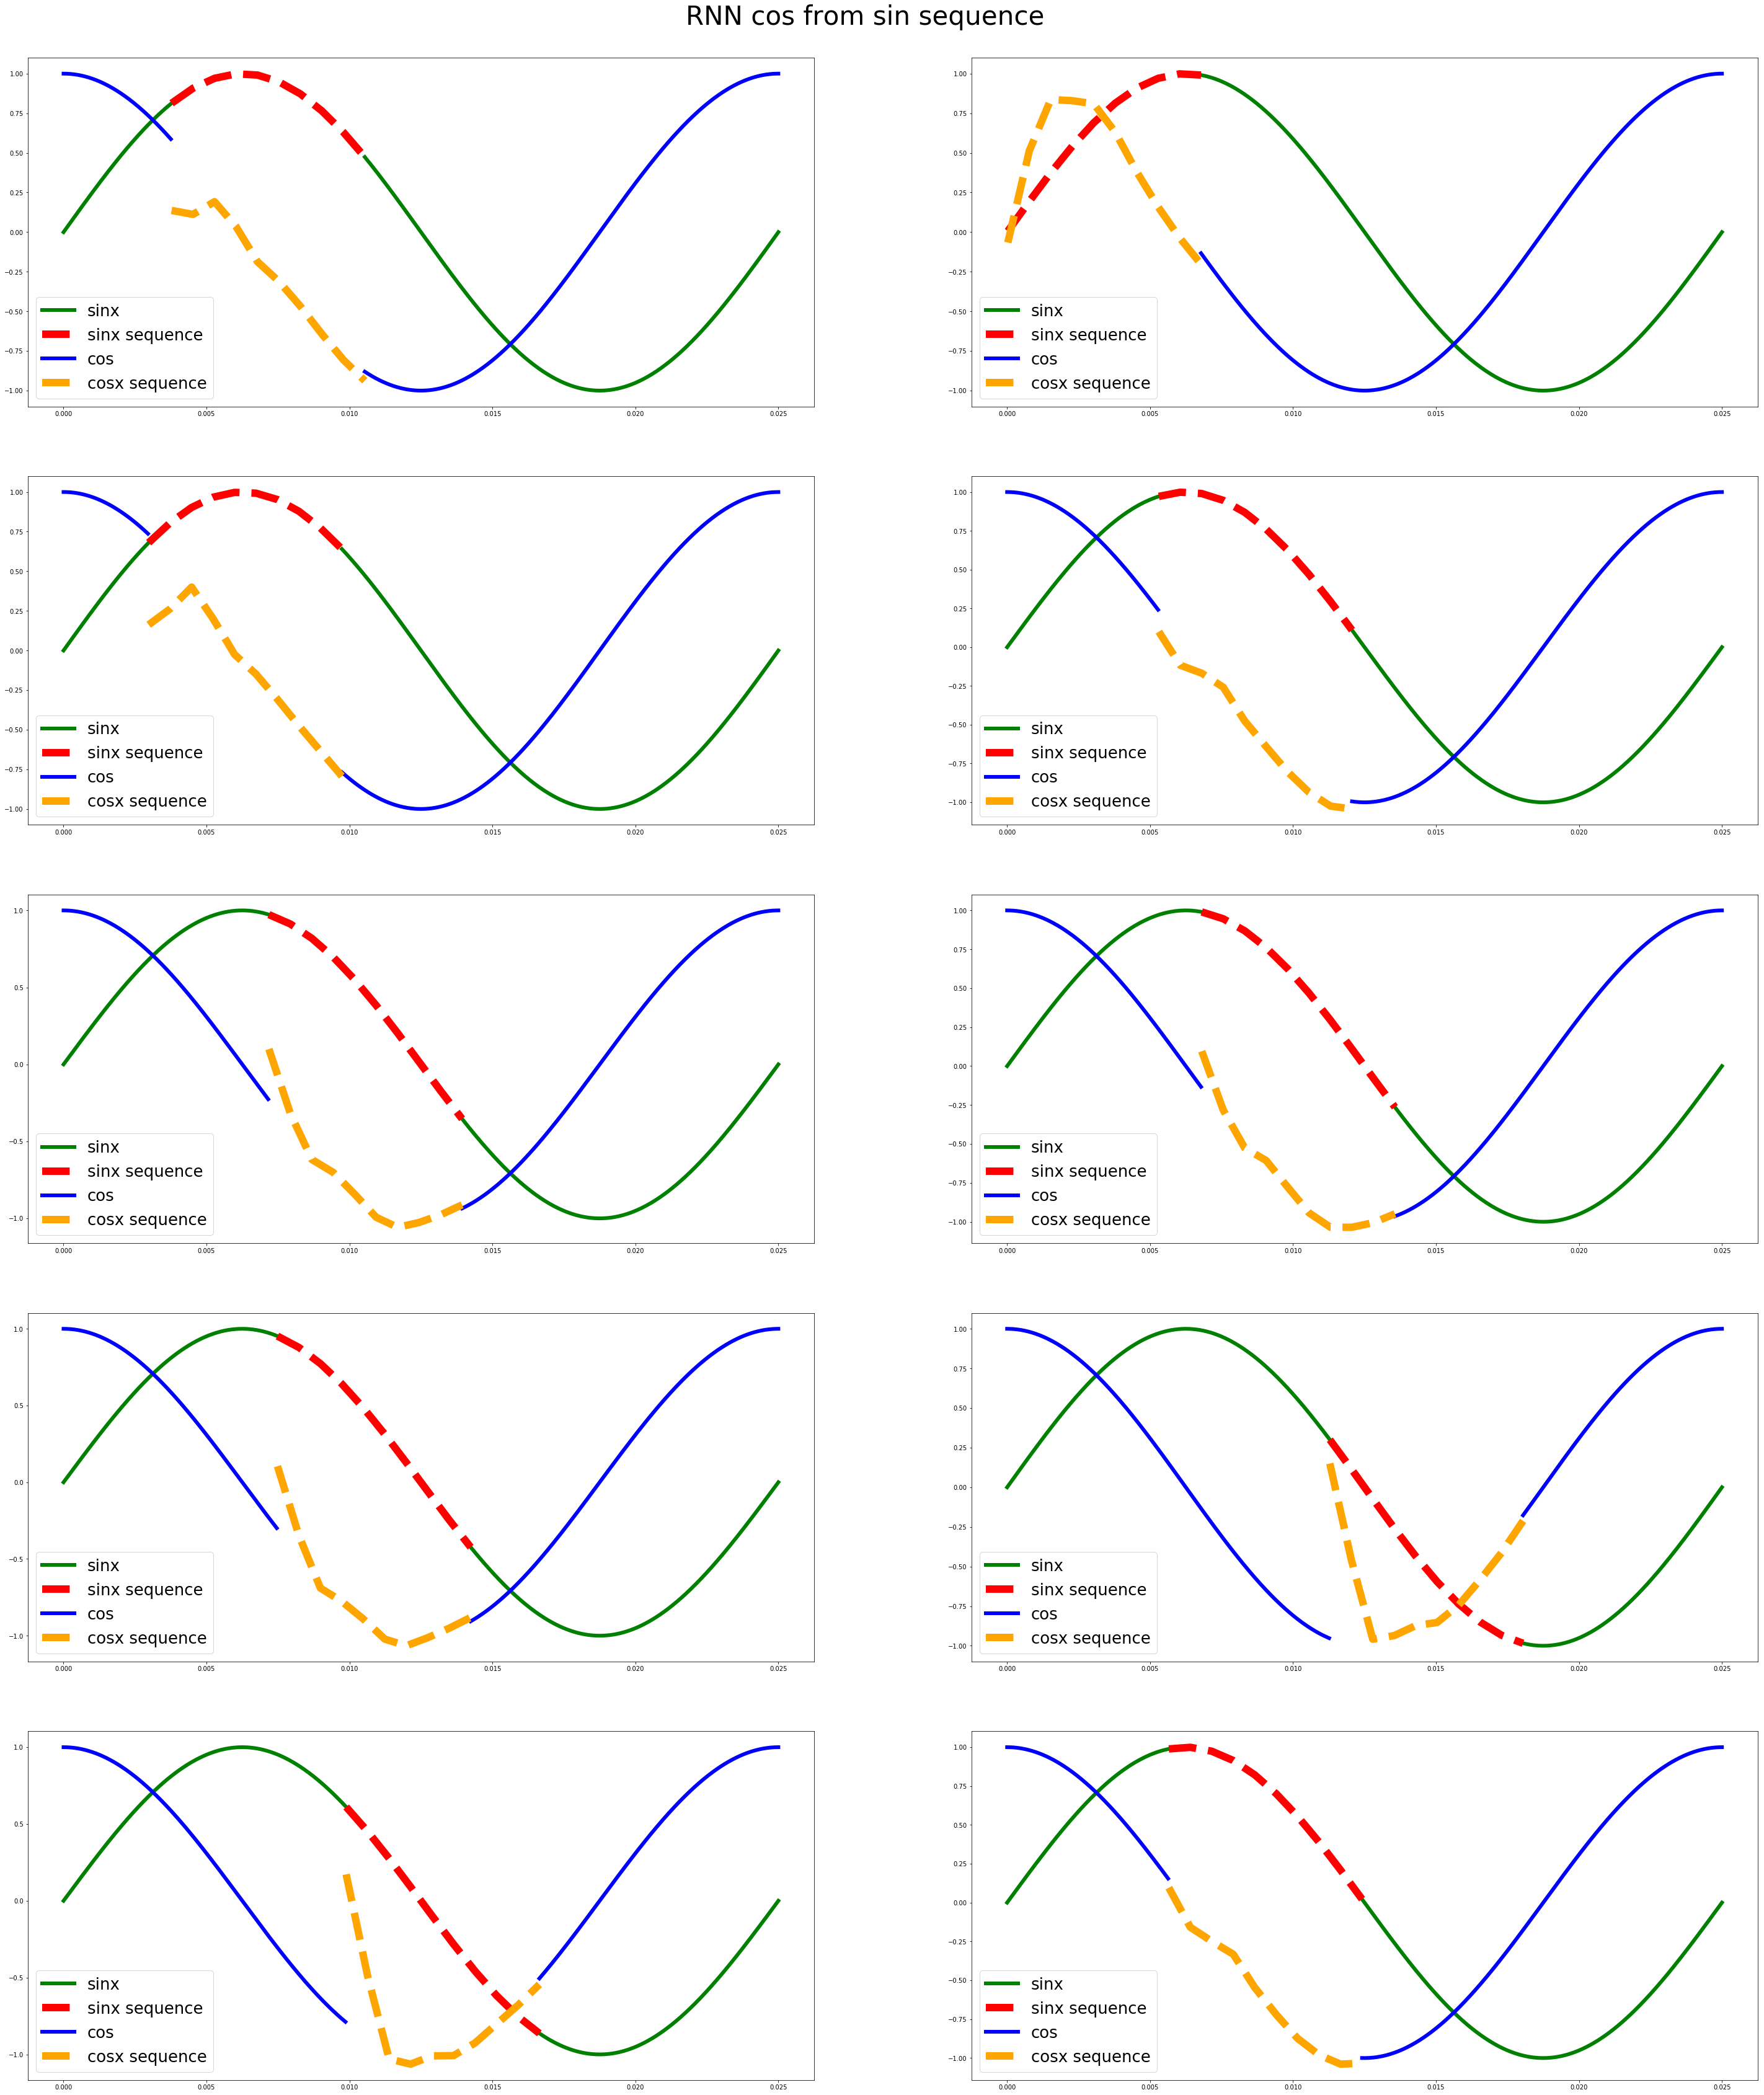

In [427]:
output, hidden = model(seqs_input3d_t)
outputValues= output.detach().numpy()

tot_rows= 5
fig, ax = plt.subplots(tot_rows, 2,figsize=(50,60))
ax = ax.flatten()
ttl= fig.suptitle('RNN cos from sin sequence',fontsize=42)
ttl.set_position([.5, 0.9])

for i in range(tot_rows*2):
    seq_input= seqs_input3d[i]
    #seq_output= seqs_output3d[i]
    seq_output= outputValues[i,:]
    seq_indx= seqs_indxs[i]
    
    ileft= list(range(0,min(seq_indx)))
    iright= list(range(max(seq_indx),tot_samples))
    ax[i].plot(x[ileft],sin[ileft],label='sinx',color='g',linewidth=6)
    ax[i].plot(x[iright],sin[iright],color='g',linewidth=6)
    ax[i].plot(x[seq_indx],seq_input.transpose()[0,:], '--', label='sinx sequence',color='r', linewidth=12)
    
    ax[i].plot(x[ileft],cos[ileft],label='cos',color='b',linewidth=6)
    ax[i].plot(x[iright],cos[iright],color='b',linewidth=6)
    ax[i].plot(x[seq_indx],seq_output, '--', label='cosx sequence',color='orange',linewidth=12)
    ax[i].legend(loc='lower left', prop={'size': 26})

We can see that the first 2-3 samples of each sequence are not being predicted well enough.<br>
This can be explained by the fact that given the starting point of a sinusoidal sequence<br>
due to the arbitary phase, the value of the next point is ambiguous.


### b) Main 

#### step 9

In [499]:
def parser(directory):
    # Parse relevant dataset info
    files = glob(os.path.join(directory, '*.wav'))
    fnames = [f.split('\\')[1].split('.')[0].split('_') for f in files]
    ids = [f[2] for f in fnames]
    y = [int(f[0]) for f in fnames]
    speakers = [f[1] for f in fnames]
    _, Fs = librosa.core.load(files[0], sr=None)

    def read_wav(f):
        global Fs
        wav, fs = librosa.core.load(f, sr=None)
        return wav

    # Read all wavs
    wavs = [read_wav(f) for f in files]

    # Extract MFCCs for all wavs
    window = 30 * Fs // 1000
    step = window // 2
    frames = [librosa.feature.mfcc(wav, Fs, n_fft=window, hop_length=window - step, n_mfcc=13).T for wav in wavs]
    # Print dataset info
    print('Total wavs: {}'.format(len(frames)))

    # Standardize data
    scaler = preprocessing.StandardScaler()
    scaler.fit(np.concatenate(frames))
    for i in range(len(frames)):
        frames[i] = scaler.transform(frames[i])

    # Split to train-test
    X_train, y_train, spk_train = [], [], []
    X_validation, y_validation, spk_validation = [], [], []
    X_test, y_test, spk_test = [], [], []
    test_indices = [str(i) for i in list(range(5))]               #5 out of 50 -> 10% train-test split
    validation_indices= [str(i) for i in list(list(range(5,14)))] #9 out of 45 (rest) -> 20% train-validation split
    for idx, frame, label, spk in zip(ids, frames, y, speakers):
        if str(idx) in test_indices:
            X_test.append(np.float_(frame))
            y_test.append(label)
            spk_test.append(spk)
        elif str(idx) in validation_indices:
            X_validation.append(np.float_(frame))
            y_validation.append(label)
            spk_validation.append(spk)
        else:
            X_train.append(np.float_(frame))
            y_train.append(label)
            spk_train.append(spk)

    return X_train, X_test, X_validation, np.array(y_train), np.array(y_test), np.array(y_validation), spk_train, spk_test, spk_validation
    

In [4]:
X_train, X_test, X_validation, y_train, y_test, y_validation, spk_train, spk_test, spk_validation= parser('data/free-spoken-digit-dataset-master/free-spoken-digit-dataset-master/recordings')

Total wavs: 2000


#### steps 10-12

In [500]:
class HmmsGmmsClassifier(BaseEstimator):  
    
    def __init__(self):
        self.models= {}
        
    
    def fit(self, X_train, y_train, n_states, n_mixtures):#n_statesL, n_mixturesL):
        
        for digit in range(10):
            
            data= [ X_train[i] for i in  np.where(y_train == digit)[0]]  # your data: must be a Python list that contains: 2D lists with the sequences (so its dimension would be num_sequences x seq_length x feature_dimension)
                                                                        # But be careful, it is not a numpy array, it is a Python list (so each sequence can have different length)
            
            X= np.vstack(data) # data from a single digit (can be a numpy array)

            #n_states, n_mixtures = n_statesL[digit], n_mixturesL[digit]
            
            gmm = True # whether to use GMM or plain Gaussian

            dists = [] # list of probability distributions for the HMM states
            for i in range(n_states):
                if gmm:
                    a = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, n_mixtures, X)
                else:
                    a = MultivariateGaussianDistribution.from_samples(X)
                dists.append(a)


            trans_mat = np.diag(np.ones(n_states), k=0)*0.5 + np.diag(np.ones(n_states-1), k=1)*.5  # transition matrix
            trans_mat[-1,-1] = 1 #last state

            starts = [1] + ((n_states-1)*[0]) # starting probability matrix
            ends = starts[::-1] # ending probability matrix

            # Define the GMM-HMM
            self.models[digit] = HiddenMarkovModel.from_matrix(trans_mat, dists, starts, ends, state_names=['s{}'.format(i) for i in range(n_states)])
            
            
            # Fit the model
            self.models[digit].fit(data, max_iterations=5, algorithm='baum-welch')
        
        return self

    def predict(self, X_test):
        self.preds_= []
        
        # Predict a sequence
        for sample in X_test:
            sample_preds= []
            for name,model in sorted(self.models.items(), key=lambda row: row[0]): #iterate throught key-ordered dictionary items 
                logp, _ = model.viterbi(sample) # Run viterbi algorithm and return log-probability
                sample_preds.append(logp)
    
            self.preds_.append(np.argmax(sample_preds))
    
        return self.preds_
    
    
    def score(self, X_test, y_test):
        
        #Even if self.predict != None, they may belong to different X_test data 
        self.predict(X_test)
        
        return np.sum(self.preds_ == y_test) / y_test.shape[0]

In [ ]:
n_statesL= list(range(1,5))
n_mixturesL= list(range(2,6))

all_scores= {}

for n_states in n_statesL:
    for n_mixtures in n_mixturesL:
        clf= HmmsGmmsClassifier().fit(X_train, y_train, n_states, n_mixtures)
        all_scores[(n_states,n_mixtures)]= clf.score(X_validation,y_validation)

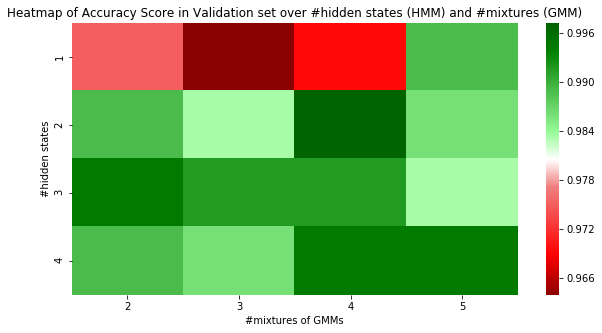

In [502]:
all_scoresArray= np.zeros((n_statesL[-1]+1,n_mixturesL[-1]+1))
for (s,m),score in all_scores.items():
    all_scoresArray[s,m]= score

c = ["darkred","red","lightcoral","white", "palegreen","green","darkgreen"]
v = [0,.15,.4,.5,0.6,.9,1.]
l = list(zip(v,c))
cmap=LinearSegmentedColormap.from_list('rg',l, N=256)

plt.figure(figsize=(10,5))
ax = sns.heatmap(all_scoresArray[n_statesL[0]:,n_mixturesL[0]:], cmap=cmap)
ax.set_xticklabels(n_mixturesL)
ax.set_yticklabels(n_statesL)
ax.set_xlabel("#mixtures of GMMs")
ax.set_ylabel("#hidden states")
ax.set_title("Heatmap of Accuracy Score in Validation set over #hidden states (HMM) and #mixtures (GMM)");

In [503]:
n_states_max,n_mixtures_max= np.argwhere(all_scoresArray.max() == all_scoresArray)[0]
print('... Parameter tunning on Validation set ...\n')
print('max Accuracy: {:0.4f}\n is given by:\n\n#hidden states: {}\n#gaussian mixtures: {}'.format(all_scoresArray.max(),n_states_max,n_mixtures_max))

... Parameter tunning on Validation set ...

max Accuracy: 0.9972
 is given by:

#hidden states: 2
#gaussian mixtures: 4


set these parameters and see the Accuracy on the test set

In [ ]:
best_HmmGmm= HmmsGmmsClassifier().fit(X_train, y_train, n_states_max, n_mixtures_max)
test_score= best_HmmGmm.score(X_test,y_test)

In [505]:
print('... Model Evaluation on Test set ...\n')
print('Accuracy: {:0.4} [Best HMM-GMM model]'.format(test_score))

... Model Evaluation on Test set ...

Accuracy: 0.975 [Best HMM-GMM model]


#### step 13

In [506]:
def plot_confusion_matrix(y_true, y_pred, fig, ax, allClasses, 
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = allClasses[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #print(cm)

    #fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

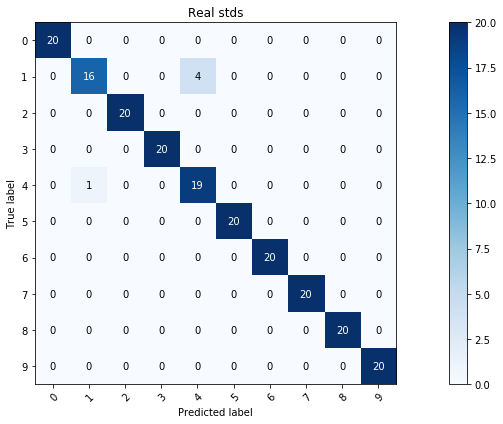

... Model Evaluation on Test set ...

Accuracy: 0.975 [Best HMM-GMM model]


In [507]:
fig, ax = plt.subplots(figsize=(15,6))

plot_confusion_matrix(y_test, best_HmmGmm.predict(X_test), fig, ax, allClasses=np.arange(10), title='Real stds');
plt.show();
print('... Model Evaluation on Test set ...\n')
print('Accuracy: {:0.4} [Best HMM-GMM model]'.format(test_score))

#### step 14

In [532]:
class BasicLSTM(nn.Module):
    
    
    def __init__(self, input_size, hidden_dim, output_size, n_layers, bidirectional=False, drop_prob=0, printing=True, pack=False):
        super(BasicLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.feature_size = (hidden_dim * 2) if self.bidirectional else hidden_dim
        self.num_directions = 2 if bidirectional else 1
        self.hidden_dim= hidden_dim
        self.output_size= output_size
        self.pack= pack
        self.my_print= print if printing else lambda *args: None
        
        # --------------- Insert your code here ---------------- #
        # Initialize the LSTM, Dropout, Output layers
        self.lstm = nn.LSTM(input_size, self.feature_size, n_layers, bidirectional=self.bidirectional, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc1 = nn.Linear(self.feature_size*self.num_directions, 64)
        self.fc2 = nn.Linear(64, self.output_size)
        
        
    def forward(self, x, lengths):
        """ 
            x : 3D numpy array of dimension N x L x D
                N: batch index
                L: sequence index
                D: feature index

            lengths: N x 1
         """
        
        # --------------- Insert your code here ---------------- #
        
        # You must have all of the outputs of the LSTM, but you need only the last one (that does not exceed the sequence length)
        # To get it use the last_timestep method
        # Then pass it through the remaining network
        
        batch_size = x.size(0)
        self.my_print('input shape:',x.shape)
        if self.pack:
            x = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True)
            self.my_print('pack padded shape:',x.data.shape)
            lstm_out, _ = self.lstm(x.float())
            self.my_print('lstm out shape:',lstm_out.data.shape)
            lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out,batch_first=True)
            self.my_print('pad packed shape:',lstm_out.shape)
        else:
            lstm_out, _= self.lstm(x)
            self.my_print('lstm out shape:',lstm_out.shape)
        
        out= self.last_timestep(lstm_out,lengths, bidirectional=self.bidirectional)
        self.my_print('last timestep shape:',out.shape)
        
        out = out.contiguous().view(batch_size, -1)
        self.my_print('last timestep converted:',out.shape)
        
        out = F.relu(self.fc1(out))
        out = F.log_softmax(self.fc2(self.dropout(out)), dim=1)
        self.my_print('dropout/fc1/fc2 out shape:',out.shape)
        self.my_print('softmax shape:',out.shape)
        
 
        return out
    

    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)

        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(0),
                                               outputs.size(2)).unsqueeze(1)
        return outputs.gather(1, idx).squeeze()

In [369]:
def train_model2(model, n_epochs, lr, criterion, optimizer, earlyStopping=None, checkpoints=None, checkValidationSet=False, pack=False):
    
    if earlyStopping:
        patience, min_delta, earlyStoppingBreak= earlyStopping['patience'], earlyStopping['min_delta'], earlyStopping['break'] 
        
    is_cuda = torch.cuda.is_available()

    if is_cuda:
        device = torch.device("cuda")
        print("GPU is available")
    else:
        device = torch.device("cpu")
        print("GPU not available, CPU used")

    model.to(device)

    train_losses= []
    val_losses= []
    alreadyStopped= False
    earlyStoppingEpoch= None
    smallest_val_error= np.inf

    # Training Run
    for epoch in range(1, n_epochs + 1):
        #training loss + weights update
        batch_loss = []
        for inputs, lengths, labels in (train_loader_p if pack else train_loader):
            optimizer.zero_grad()
            output = model(inputs, lengths)
            #print(output.shape, labels.shape)
            loss = criterion(output, labels)
            batch_loss.append(loss.item())
            loss.backward()
            optimizer.step()
        train_loss= np.mean(batch_loss)
        train_losses.append(train_loss)    
        
        
        #validation loss
        if earlyStopping or checkValidationSet:
            with torch.no_grad():
                batch_loss = []
                for inputs, lengths, labels in (validation_loader_p if pack else validation_loader):
                    output = model(inputs, lengths)
                    loss = criterion(output, labels)
                    batch_loss.append(loss.item())

            val_loss= np.mean(batch_loss)
            val_losses.append(val_loss)

        #if epoch%10 == 0:
        print('...... epoch: {}/{} ......\t'.format(epoch, n_epochs), end='')
        print('train loss {:.4f}'.format(train_loss), end='')
        if earlyStopping or checkValidationSet:
            print('    validation loss {:.4f}'.format(val_loss), end='')

        
        if checkpoints and not alreadyStopped and  val_losses[-1] < smallest_val_error:
            smallest_val_error= val_losses[-1]
            save_model(model,epoch,optimizer,train_loss,val_loss,filename=checkpoints['filename'])
            print('    saving model', end='')
        elif earlyStopping and not alreadyStopped and epoch>patience:
            last_scores= val_losses[-patience:]
            if last_scores[0] == min(last_scores) or abs(last_scores[0]-min(last_scores)) < min_delta:
                print('\nEarly Stopping at epoch',epoch)
                alreadyStopped= True
                earlyStoppingEpoch= epoch-patience
                if earlyStoppingBreak:
                    break
            
        print('\n')

    return train_losses, val_losses, earlyStoppingEpoch


def save_model(model,epoch,optimizer,train_loss,val_loss,filename='checkpoint.pt'):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_los': val_loss
            }, picklesPath+filename)

def print_loss_curve(train_losses,val_losses,earlyStoppingEpoch=None):
    plt.figure(figsize=(10,4))
    if train_losses and val_losses:
        plt.plot(train_losses,label='train loss',color='b')
        plt.plot(val_losses,label='validation loss',color='g')
        if earlyStoppingEpoch:
            plt.axvline(earlyStoppingEpoch,linestyle='--',label='Early Stopping checkpoint',color='r')
        plt.legend()
        plt.title('Training/Validation Loss')
        plt.show()
    else:
        plt.plot(train_losses)
        plt.title('Training Loss')
        plt.show()

In [367]:
from torch.utils.data import Dataset, DataLoader

class FrameLevelDataset(Dataset):
    def __init__(self, feats, labels, max_seq_len, sort=False):
        """
            feats: Python list of numpy arrays that contain the sequence features.
                   Each element of this list is a numpy array of shape seq_length x feature_dimension
            labels: Python list that contains the label for each sequence (each label must be an integer)
        """
        
        self.lengths= torch.LongTensor(torch.from_numpy(  np.array([len(f) for f in feats])  ).long())
        
        mask = np.argsort(-self.lengths) if sort else np.arange(len(self.lengths))
        
        self.lengths= self.lengths[mask]
        self.feats= self.zero_pad_and_stack(feats, max_seq_len)[mask]
        self.labels= torch.LongTensor( np.array(labels).astype('int64') )[mask]
        self.len= self.feats.shape[0]

        
    def zero_pad_and_stack(self, X_list, max_seq_len):
        """
            This function performs zero padding on a list of features and forms them into a numpy 3D array
            returns
                padded: a 3D numpy array of shape num_sequences x max_sequence_length x feature_dimension
        """
        X_array_p = []
        for X in X_list:
            seq_len= X.shape[0]
            X_array_p.append(np.pad(X,[[0,max_seq_len-seq_len],[0,0]]))

        return torch.FloatTensor(torch.from_numpy(  np.array(X_array_p)  ).float())
    
    
    def __len__(self):
          return self.len
        
    def __getitem__(self,idx):
        return self.feats[idx], self.lengths[idx], self.labels[idx],

get all the loaders

In [258]:
max_seq_len= max([max([seq.shape[0] for seq in X_train]),max([seq.shape[0] for seq in X_validation]),max([seq.shape[0] for seq in X_test])])
batch_size= 32

train_set= FrameLevelDataset(X_train,y_train,max_seq_len)
train_loader= DataLoader(dataset=train_set, shuffle=False, batch_size=batch_size)

test_set= FrameLevelDataset(X_test,y_test,max_seq_len)
test_loader= DataLoader(dataset=test_set, shuffle=False, batch_size=batch_size)

validation_set= FrameLevelDataset(X_validation,y_validation,max_seq_len)
validation_loader= DataLoader(dataset=validation_set, shuffle=False, batch_size=batch_size)


#Pack Padded Sequence
train_set_p= FrameLevelDataset(X_train,y_train,max_seq_len,sort=True)
train_loader_p= DataLoader(dataset=train_set_p, shuffle=False, batch_size=batch_size)

test_set_p= FrameLevelDataset(X_test,y_test,max_seq_len,sort=True)
test_loader_p= DataLoader(dataset=test_set_p, shuffle=False, batch_size=batch_size)

validation_set_p= FrameLevelDataset(X_validation,y_validation,max_seq_len,sort=True)
validation_loader_p= DataLoader(dataset=validation_set_p, shuffle=False, batch_size=batch_size)

training and validation loss per epoch

GPU not available, CPU used
...... epoch: 1/100 ......	train loss 2.4502    validation loss 2.3231    saving model

...... epoch: 2/100 ......	train loss 2.4164    validation loss 2.3116    saving model

...... epoch: 3/100 ......	train loss 2.4268    validation loss 2.2836    saving model

...... epoch: 4/100 ......	train loss 2.3399    validation loss 2.2769    saving model

...... epoch: 5/100 ......	train loss 2.3284    validation loss 2.2221    saving model

...... epoch: 6/100 ......	train loss 2.3153    validation loss 2.1890    saving model

...... epoch: 7/100 ......	train loss 2.2855    validation loss 2.2767

...... epoch: 8/100 ......	train loss 2.3560    validation loss 2.2442

...... epoch: 9/100 ......	train loss 2.2821    validation loss 2.0569    saving model

...... epoch: 10/100 ......	train loss 2.1477    validation loss 2.2344

...... epoch: 11/100 ......	train loss 2.2185    validation loss 1.9478    saving model

...... epoch: 12/100 ......	train loss 2.0210    v

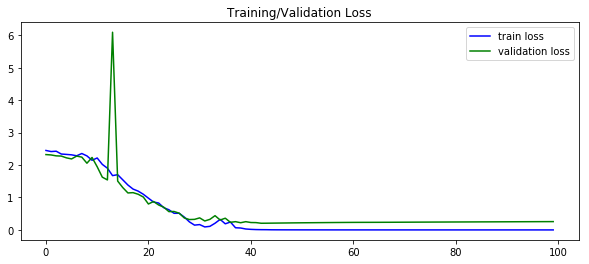

In [540]:
#input_dim, hidden_dim, output_dim, num_layers
model = BasicLSTM(13, 50, 10, 1, printing=False)

n_epochs = 100
lr=0.01
checkpoints={
    'filename': 'case1.pt'
}

criterion = nn.CrossEntropyLoss() #nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses, val_losses, earlyStoppingEpoch= train_model2(model, n_epochs, lr, criterion, optimizer, checkpoints=checkpoints, checkValidationSet=True)

print_loss_curve(train_losses,val_losses,earlyStoppingEpoch)

same as above, using pack_padded + early stopping

* pack_padded_sequence and pad_packed_sequence: less training time because backprobagation algortithm does not consider the padded elements 
* early stopping: when there are patience epochs without improvement of the validation loss stop. the best model is the model with the smallest validation loss  -> prevents overfitting

GPU not available, CPU used
...... epoch: 1/100 ......	train loss 1.6122    validation loss 1.8775    saving model

...... epoch: 2/100 ......	train loss 1.1970    validation loss 0.9945    saving model

...... epoch: 3/100 ......	train loss 0.7290    validation loss 0.8668    saving model

...... epoch: 4/100 ......	train loss 0.6019    validation loss 0.6357    saving model

...... epoch: 5/100 ......	train loss 0.4826    validation loss 0.4977    saving model

...... epoch: 6/100 ......	train loss 0.3654    validation loss 0.4452    saving model

...... epoch: 7/100 ......	train loss 0.3523    validation loss 0.4925

...... epoch: 8/100 ......	train loss 0.2823    validation loss 0.3526    saving model

...... epoch: 9/100 ......	train loss 0.1833    validation loss 0.2929    saving model

...... epoch: 10/100 ......	train loss 0.1144    validation loss 0.3241

...... epoch: 11/100 ......	train loss 0.1590    validation loss 0.2366    saving model

...... epoch: 12/100 ......	train 

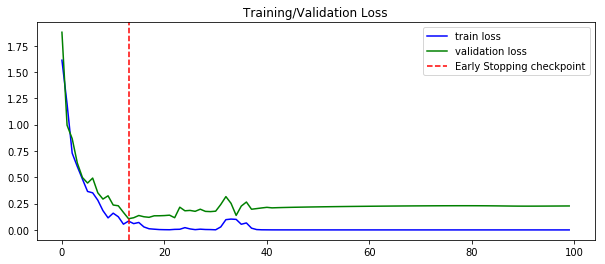

In [541]:
#input_dim, hidden_dim, output_dim, num_layers
pack=True
model = BasicLSTM(13, 50, 10, 1, printing=False, pack=pack)

n_epochs = 100
lr=0.01
earlyStopping= {
    'patience': 30,
    'min_delta': 1e-5,
    'break': False
}
checkpoints={
    'filename': 'case2.pt'
}

criterion = nn.CrossEntropyLoss() #nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses, val_losses, earlyStoppingEpoch= train_model2(model, n_epochs, lr, criterion, optimizer, checkpoints=checkpoints, earlyStopping=earlyStopping, pack=pack)

print_loss_curve(train_losses,val_losses,earlyStoppingEpoch)

Dropout (drop_prob) and  L2-Regularization (weight_decay)

* Dropout: partial learning of weights over iterations -> prevents overfitting
* L2-Regularization: additional penalty term (Euclidean norm) to the loss function -> weight values doesn't grow -> prevents overfitting

GPU not available, CPU used
...... epoch: 1/200 ......	train loss 1.6340    validation loss 2.1509    saving model

...... epoch: 2/200 ......	train loss 1.4063    validation loss 1.5420    saving model

...... epoch: 3/200 ......	train loss 1.1624    validation loss 1.2125    saving model

...... epoch: 4/200 ......	train loss 0.9567    validation loss 1.0516    saving model

...... epoch: 5/200 ......	train loss 0.8713    validation loss 1.0356    saving model

...... epoch: 6/200 ......	train loss 0.7745    validation loss 0.5620    saving model

...... epoch: 7/200 ......	train loss 0.5006    validation loss 0.7472

...... epoch: 8/200 ......	train loss 0.4254    validation loss 0.5215    saving model

...... epoch: 9/200 ......	train loss 0.3714    validation loss 0.3737    saving model

...... epoch: 10/200 ......	train loss 0.3791    validation loss 0.3601    saving model

...... epoch: 11/200 ......	train loss 0.3555    validation loss 0.5562

...... epoch: 12/200 ......	train 

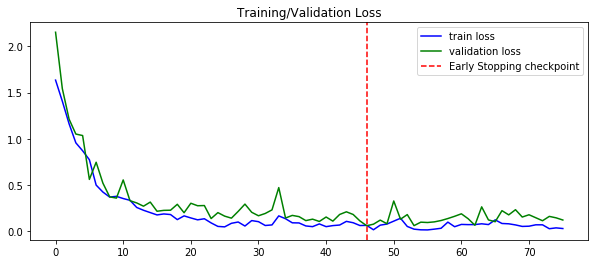

In [543]:
#input_dim, hidden_dim, output_dim, num_layers
pack=True
model = BasicLSTM(13, 50, 10, 2, drop_prob=0.1, printing=False, pack=pack)

n_epochs = 200
lr=0.01
earlyStopping= {
    'patience': 30,
    'min_delta': 1e-5,
    'break': True
}
checkpoints={
    'filename': 'case3.pt'
}

criterion = nn.CrossEntropyLoss() #nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)

train_losses, val_losses, earlyStoppingEpoch= train_model2(model, n_epochs, lr, criterion, optimizer, checkpoints=checkpoints, earlyStopping=earlyStopping, pack=pack)


print_loss_curve(train_losses,val_losses,earlyStoppingEpoch)

Bidirectional LSTM
    * Bi-LSTM take into account future input information

GPU not available, CPU used
...... epoch: 1/200 ......	train loss 1.1481    validation loss 1.5446    saving model

...... epoch: 2/200 ......	train loss 0.6381    validation loss 0.7511    saving model

...... epoch: 3/200 ......	train loss 0.4039    validation loss 0.7617

...... epoch: 4/200 ......	train loss 0.4393    validation loss 0.3841    saving model

...... epoch: 5/200 ......	train loss 0.1874    validation loss 0.3980

...... epoch: 6/200 ......	train loss 0.1284    validation loss 0.2030    saving model

...... epoch: 7/200 ......	train loss 0.2662    validation loss 0.4170

...... epoch: 8/200 ......	train loss 0.1228    validation loss 0.2659

...... epoch: 9/200 ......	train loss 0.1090    validation loss 0.1539    saving model

...... epoch: 10/200 ......	train loss 0.0636    validation loss 0.1192    saving model

...... epoch: 11/200 ......	train loss 0.0430    validation loss 0.1194

...... epoch: 12/200 ......	train loss 0.0224    validation loss 0.0577    saving 

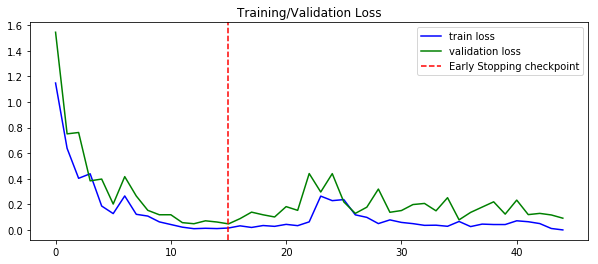

In [544]:
#input_dim, hidden_dim, output_dim, num_layers
pack=True
model = BasicLSTM(13, 50, 10, 2, drop_prob=0.1, bidirectional=True, printing=False, pack=pack)

n_epochs = 200
lr=0.01
earlyStopping= {
    'patience': 30,
    'min_delta': 1e-5,
    'break': True
}
checkpoints={
    'filename': 'case4.pt'
}


criterion = nn.CrossEntropyLoss() #nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses, val_losses, earlyStoppingEpoch= train_model2(model, n_epochs, lr, criterion, optimizer, checkpoints=checkpoints, earlyStopping=earlyStopping, pack=pack)


print_loss_curve(train_losses,val_losses,earlyStoppingEpoch)

same as before, without dropout

GPU not available, CPU used
...... epoch: 1/200 ......	train loss 1.0479    validation loss 1.5205    saving model

...... epoch: 2/200 ......	train loss 0.6441    validation loss 0.8196    saving model

...... epoch: 3/200 ......	train loss 0.4760    validation loss 0.5131    saving model

...... epoch: 4/200 ......	train loss 0.2425    validation loss 0.3422    saving model

...... epoch: 5/200 ......	train loss 0.1437    validation loss 0.4152

...... epoch: 6/200 ......	train loss 0.1420    validation loss 0.1301    saving model

...... epoch: 7/200 ......	train loss 0.1141    validation loss 0.1629

...... epoch: 8/200 ......	train loss 0.0836    validation loss 0.0571    saving model

...... epoch: 9/200 ......	train loss 0.0519    validation loss 0.1357

...... epoch: 10/200 ......	train loss 0.0480    validation loss 0.1560

...... epoch: 11/200 ......	train loss 0.0399    validation loss 0.1031

...... epoch: 12/200 ......	train loss 0.0460    validation loss 0.0549    saving 

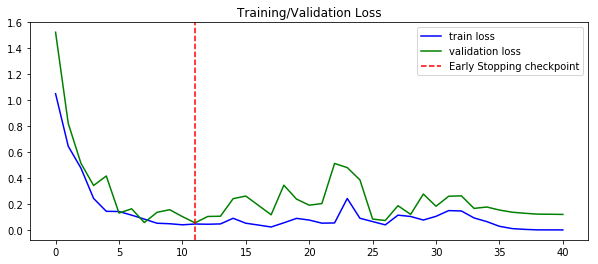

In [545]:
#input_dim, hidden_dim, output_dim, num_layers
pack=True
model = BasicLSTM(13, 50, 10, 2, bidirectional=True, printing=False, pack=pack)

n_epochs = 200
lr=0.01
earlyStopping= {
    'patience': 30,
    'min_delta': 1e-5,
    'break': True
}
checkpoints={
    'filename': 'case5.pt'
}


criterion = nn.CrossEntropyLoss() #nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses, val_losses, earlyStoppingEpoch= train_model2(model, n_epochs, lr, criterion, optimizer, checkpoints=checkpoints, earlyStopping=earlyStopping, pack=pack)


print_loss_curve(train_losses,val_losses,earlyStoppingEpoch)

### Get the best model 

In [546]:
model = BasicLSTM(13, 50, 10, 2, drop_prob=0.1, bidirectional=True, printing=False, pack=pack)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

checkpoint = torch.load('case4.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss= checkpoint['val_los']

print('this is the best model\n')

model.eval()

this is the best model



BasicLSTM(
  (lstm): LSTM(13, 100, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (dropout): Dropout(p=0.1)
  (fc1): Linear(in_features=200, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [548]:
loaders= [train_loader_p, validation_loader_p, test_loader_p]
loadersNames= ['train set', 'validation set', 'test set']

for i,loader in enumerate(loaders):
    outs, labs= [], []
    for inputs, lengths, labels in loader:
        output = model(inputs, lengths)
        outs.append(np.argmax(output.detach().numpy(),axis=1))
        labs.append(labels.detach().numpy())
    
    outs= [x for out in outs for x in out]
    labs= [x for lab in labs for x in lab]
    total= len(labs)
    TP= sum( np.equal(outs, labs) )     
    print('Accuracy {:0.3f}% [{}]'.format(TP/total, loadersNames[i]))

Accuracy 0.999% [train set]
Accuracy 0.981% [validation set]
Accuracy 0.990% [test set]


model evaluation on test set

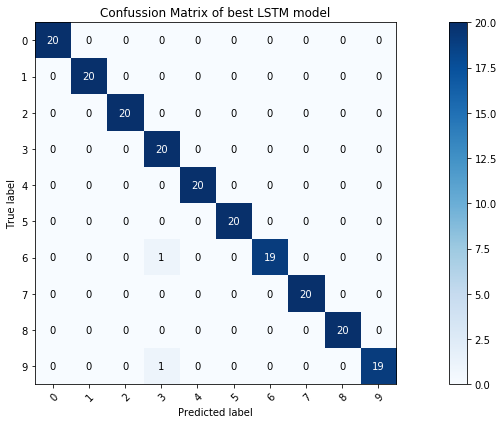

In [549]:
fig, ax = plt.subplots(figsize=(15,6))
plot_confusion_matrix(labs, outs, fig, ax, allClasses=np.arange(10), title='Confussion Matrix of best LSTM model');
plt.show();